### Data Process

In [1]:
import numpy as np
import copy
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import networkx as nx
import scipy.io as io
from scipy.sparse import coo_matrix
import pandas as pd

In [2]:
data = io.mmread('./data/neuron1k/matrix.mtx')
data = data.T
# num_cells x num_genes

In [3]:
data

<1301x31053 sparse matrix of type '<class 'numpy.int64'>'
	with 4220492 stored elements in COOrdinate format>

In [4]:
masked_prob = min(len(np.where(data.todense() != 0)[0]) / (data.todense().shape[0] * data.todense().shape[1]), 0.3)
print(masked_prob)

0.10446774529663438


In [5]:
raw = pd.DataFrame(data.todense()) # dimension = (cells x genes)data

In [6]:
def filter_genes(gene_metric, threshold, NN_lim=None):
    
    if not str(NN_lim).isdigit():
        NN_lim = (gene_metric > threshold).sum()
    
    genes_to_impute = gene_metric.index[:NN_lim]

    print("{} genes selected for imputation".format(len(genes_to_impute)))

    return genes_to_impute


gene_metric = (raw.var()/(1+raw.mean())).sort_values(ascending=False)
gene_metric = gene_metric[gene_metric > 0]

genes_to_impute = filter_genes(gene_metric, 0.5)

4515 genes selected for imputation


In [7]:
data = data.tocsr()[:, genes_to_impute]

In [8]:
# normalize cell counts
rowsum = np.sum(data, axis = 1)
norm_transcript = np.median(np.asarray(rowsum))

In [9]:
norm_transcript

8435.0

In [10]:
rowsum.shape

(1301, 1)

In [11]:
data_norm = (data/rowsum.reshape(-1,1))*norm_transcript

In [12]:
data_norm.shape

(1301, 4515)

In [13]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv 
from torch_geometric.data import Data
from scipy.stats import pearsonr

In [14]:
seed = 1
split = [0.9, 0.05, 0.05]
np.random.seed(seed)
test_val = np.random.choice(data_norm.shape[0], int(data_norm.shape[0] * (split[1] + split[2])), replace = False)
train = [i for i in list(range(data_norm.shape[0])) if i not in test_val]
np.random.seed(seed)
test = np.random.choice(test_val, int(len(test_val) * (split[2] / (split[1] + split[2]))), replace = False)
val = [i for i in test_val if i not in test]

data_train = data_norm[train]
data_val = data_norm[val]
data_test = data_norm[test]
data_train.shape

# data mask
print(masked_prob)

def mask(data_train, masked_prob):
    index_pair_train = np.where(data_train != 0)
    np.random.seed(seed)
    masking_idx_train = np.random.choice(index_pair_train[0].shape[0], int(index_pair_train[0].shape[0] * masked_prob), replace = False)
    #to retrieve the position of the masked: data_train[index_pair_train[0][masking_idx], index_pair[1][masking_idx]]
    X_train = copy.deepcopy(data_train)
    X_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]] = 0
    return X_train, index_pair_train, masking_idx_train

X_train, index_pair_train, masking_idx_train = mask(data_train, masked_prob)
X_val, index_pair_val, masking_idx_val = mask(data_val, masked_prob)
X_test, index_pair_test, masking_idx_test = mask(data_test, masked_prob)

X_norm, _, _ = mask(data_norm, masked_prob)

X = np.vstack((X_train, X_val, X_test))

#data_order = np.vstack((data_train, data_val, data_test))
# apply pca to construct graph
pca = PCA(n_components=50)
data_pca = pca.fit_transform(X)
print(sum(pca.explained_variance_ratio_)) 

k = 5
A = kneighbors_graph(data_pca, k, mode='connectivity', include_self=False)
G = nx.from_numpy_matrix(A.todense())

# prepare for pytorch geometric data loading
edges = []
for (u, v) in G.edges():
    edges.append([u, v])
    edges.append([v, u])

edges = np.array(edges).T
print(edges.shape)
edges = torch.tensor(edges, dtype = torch.long)

feat = torch.tensor(X, dtype=torch.float)
G_data = Data(x=feat, edge_index=edges)

class Net(torch.nn.Module):
    def __init__(self, G_data):
        super(Net, self).__init__()
        self.conv1 = GCNConv(G_data.num_features, int(G_data.num_features/64))
        self.conv2 = GCNConv(int(G_data.num_features/64), G_data.num_features)

    def forward(self):
        x, edge_index = G_data.x, G_data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, G_data = Net(G_data).to(device), G_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-4)

def train_wrapper(model):
    model.train()
    optimizer.zero_grad()
    pred = model()
    dropout_pred = pred[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]
    dropout_true = data_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]

    loss_fct = nn.MSELoss()
    loss = loss_fct(dropout_pred, torch.tensor(dropout_true, dtype = torch.float).to(device))
    loss.backward()
    optimizer.step()
    loss_train = loss

    loss = val_wrapper(model)

    return loss_train.item(), loss

@torch.no_grad()
def val_wrapper(model):
    model.eval()
    pred, accs = model(), []
    dropout_pred = pred[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    dropout_true = data_val[index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    loss_fct = nn.MSELoss()
    loss = loss_fct(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))    
    return loss.item()

@torch.no_grad()
def test_wrapper(model):
    model.eval()
    pred, accs = model(), []
    dropout_pred = pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    dropout_true = data_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    loss_fct = nn.MSELoss()
    loss = loss_fct(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))    
    return loss.item()

@torch.no_grad()
def predict(model):
    model.eval()
    pred, accs = model(), []
    dropout_pred = pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    dropout_true = data_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    return dropout_pred, dropout_true

for epoch in range(1, 1001):
    train_loss, val_loss = train_wrapper(model)
    if epoch % 10 == 0:
        print('Epoch: {}, Training Loss {:.4f}, Validation Loss {:.4f}'.format(epoch, train_loss, val_loss))

loss_test = test_wrapper(model)
print('Testing Loss{:.4f} '.format(loss_test))

dropout_pred, dropout_true = predict(model)

print(pearsonr(dropout_pred.cpu().numpy(), np.asarray(dropout_true).reshape(-1,)))

0.10446774529663438
0.9859453885187708
(2, 10114)


/home/kh278/cuda92_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 258867])) that is different to the input size (torch.Size([258867])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/kh278/cuda92_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 14057])) that is different to the input size (torch.Size([14057])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10, Training Loss 512.5312, Validation Loss 215.4298
Epoch: 20, Training Loss 380.6662, Validation Loss 74.5294
Epoch: 30, Training Loss 325.6030, Validation Loss 46.9309
Epoch: 40, Training Loss 299.4128, Validation Loss 46.5363
Epoch: 50, Training Loss 270.6355, Validation Loss 39.5932
Epoch: 60, Training Loss 226.1811, Validation Loss 38.5997
Epoch: 70, Training Loss 193.4628, Validation Loss 37.2630
Epoch: 80, Training Loss 167.3104, Validation Loss 35.4524
Epoch: 90, Training Loss 113.9325, Validation Loss 33.7186
Epoch: 100, Training Loss 76.6272, Validation Loss 33.4506
Epoch: 110, Training Loss 81.5479, Validation Loss 36.1306
Epoch: 120, Training Loss 60.1542, Validation Loss 36.7159
Epoch: 130, Training Loss 45.9675, Validation Loss 36.7899
Epoch: 140, Training Loss 43.9726, Validation Loss 38.6742
Epoch: 150, Training Loss 46.8686, Validation Loss 40.2992
Epoch: 160, Training Loss 41.0719, Validation Loss 45.1149
Epoch: 170, Training Loss 47.9002, Validation Loss 41.6

/home/kh278/cuda92_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 13102])) that is different to the input size (torch.Size([13102])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


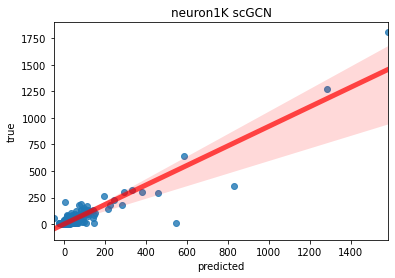

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=dropout_pred.cpu().numpy(), y=np.asarray(dropout_true).reshape(-1,), line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title('neuron1K scGCN')
plt.xlabel('predicted')
plt.ylabel('true')
plt.savefig('neuron1k_correlation.pdf')